**Flow Rate Profile Analysis**

Use with any microfluidic chip, place the black line over the channel to analyze flow across the channel. Specify number of channels and channel gaps.

Feb 2022 - Lane Breshears, modified from .py code Alex Day

Mar 2023 - Yisha Tang, modified for eNAMPT: check the example boards before running video analysis; merge multichannel data to one sheet and give threshold-cleaned flow profile

Feb 2024 - Yisha Tang, modified for PFAS: new section of data analysis and visualization to further clean the flow profile, analyze flow rate at adjustable time range.
  - Mar 14: Use the maxiuma variation to locate the initial start if variation doesn't meet the threshold; new funtion - drop the messy data.

Apr 2024 - Yisha Tang, goal for this modification:
- Multiple line along one channel for flow extraction
- ML framework (start from SVM)


# Setup

**Link CoLab code with your Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Link CoLab code with Google Sheets**

In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [4]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


**Import Libraries**


In [5]:
from tensorflow.python.util.tf_export import get_canonical_name_for_symbol
import numpy as np
import cv2
import os
import csv
import matplotlib.pyplot as plt
import sys
from google.colab.patches import cv2_imshow #to see images, can be deleted later
import pandas as pd

import gspread_dataframe as gd
import gspread as gs
import statistics as stat

##**Define Functions**

In [6]:
def defineLane(start, end):
	'''
	Auxilliary function used to correctly determine which pixels to look at in the lane, regardless of whether the pixel
	numbers go from high to low or low to high
	'''
	points = []
	temp = end - start
	if temp < 0:
		for i in range(end, start):
			points.append(i)
	else:
		for i in range(start, end):
			points.append(i)
	return points

In [7]:
def examplebounds_multiLane(videoName, location, start, end, axes, channelgap, channelnum,
                            lanestep=3, lanenum=5, frame=100):
  '''
  Given a video file, the function will show a grayscale image depicting where the analysis algorithm would consider
  the lane to be (by using a solid black line over the first frame of the video)

  Parameters:
  "videoName" = the file name of the video file
  "location" = if the axis is horizontal, then location is the pixel row containing the desired lane, while if the
          axis vertical, then location is the pixel column contained the desired lane
  "start" = the starting pixel in the row/column (dictated by "Location" parameter) of the desired lane
  "end" = the ending pixel in the row/column (dictated by the "Location" parameter) of the desired lane
  "axes" = determines whether the desired flow lane is horizontal or vertical in the video file (MUST BE EITHER "H" OR "V")
  "lanestep" = the distance between each lane, default is 3 pixels since each lane will use data in 3-pixel-width
  "lanenum" = the number of lane will be created in one channel
  "frame" = the desired frame of video to view
  '''

  if axes not in ['H', 'V']:
    print('Axes parameter not allowed, must be either H or V')
    sys.exit()
  if lanenum%2==0:
    print(f"Only odd number is acceptable as the number of lane! Current lanenum is {lanenum}")
    sys.exit()

  # make sure end value is larger than start value
  # so that start:end can be the index
  if start > end:
    tmp = start
    start = end
    end = tmp

  # a list recording the shifts of each lane from the middle lane
  laneshift = np.arange(-int(lanenum/2), int(lanenum/2)+1, step = 1) * lanestep

  video = cv2.VideoCapture(videoName)
  print('Video name: {}'.format(videoName))
  print('Video length (frames): {}'.format(video.get(cv2.CAP_PROP_FRAME_COUNT)))
  print('Video FPS (framerate): {}'.format(video.get(cv2.CAP_PROP_FPS)))
  video.set(cv2.CAP_PROP_POS_FRAMES, frame)
  success, image = video.read()
  if success:
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if axes == 'H':
      for i in range(channelnum):
        # draw black lines with given laneshift in one channel
        gray[location+channelgap*i+laneshift, start:end] = 0
    elif axes == 'V':
      for i in range(channelnum):
        gray[start:end, location+channelgap*i+laneshift] = 0
    #cv2.imwrite('test bounds.png', gray) # save the test bounds, not necessary
    cv2_imshow(gray)
  else:
    print('Video reading failed, please check the video file name!')
  video.release()

In [8]:
def flowAnalysis(videoName, location, start, end, axes, threshold=10, framestart=100, duration=350):
  '''
  Given a video file, return a list of the flow profile of the moving front. Each index will represent a frame of the
  original video file, and its value will represent how many pixels the wetting front has flowed through

  Parameters:
  "videoName" = the file name of the video file
  "Location" = if the axis is horizontal, then location is the pixel row containing the desired lane, while if the
          axis vertical, then location is the pixel column contained the desired lane
  "start" = the starting pixel in the row/column (dictated by "Location" parameter) of the desired lane
  "end" = the ending pixel in the row/column (dictated by the "Location" parameter) of the desired lane
  "axes" = determines whether the desired flow lane is horizontal or vertical in the video file (MUST BE EITHER "H" OR "V")
  "threshold" = the brightness change in a pixel within the flow lane that is considered to be high enough to count to the flow
  "framestart" = the starting frame of the video file to be analyzed
  "duration" = the duration (frames) to be analyzed from the starting frame
  '''

  # NOTE: if you're not seeing any movement in your data, change this threshold value! It represents the brightness change
  # in a pixel within the flow lane that is considered to be high enough to conclude that the moving front has moved to
  # that location.

  laneLength = defineLane(start, end)

  flowProfile = []
  video = cv2.VideoCapture(videoName)
  video.set(cv2.CAP_PROP_POS_FRAMES, framestart)

  #print('Video name: {}'.format(videoName))
  #print('Video length (frames): {}'.format(video.get(cv2.CAP_PROP_FRAME_COUNT)))
  initialLane = []

  for imagenumber in range(0, duration):
    success, image = video.read()
    if success:
      image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

      # Get a list of grayscale value along the channel (averaged from 3-pixel width)
      # initialLane: the first frame
      # currentLane: grayscale value of the current frame
      if initialLane == []:
        for i in laneLength:
          triplet = []
          for j in range(-1, 2):
            if axes == 'H':
              triplet.append(gray[location + j, i])
            elif axes == 'V':
              triplet.append(gray[i, location + j])
          initialLane.append(np.average(triplet))

      currentLane = []
      for i in laneLength:
        triplet = []
        for j in range(-1, 2):
          if axes == 'H':
              triplet.append(gray[location + j, i])
          elif axes == 'V':
            triplet.append(gray[i, location + j])
        currentLane.append(np.average(triplet))

      # Compare the currentLane to intialLane
      # Records how many pixels has a intensity change over the threshold, which is the flow distance
      differences = 0
      for i in range(0, len(laneLength)):
        difference = initialLane[i] - currentLane[i]
        if difference >= threshold:
          differences += 1

      flowProfile.append(differences)

  return flowProfile

In [9]:
def flowCutoff(data, cutoff=20):
  '''
  Cut the flow profile to remove the initial plauteu stage, and have a start around at the cutoff value.
  It will search the fist value less than the cutoff from the back of the list, and cut from there.

  Parameters:
  "data" = the flow profile to be cut
  "cutoff" = the distance (pixels) you want the cut flow profile to start from
  '''
  for i in range(len(data)):
    if data[-(i+1)]<=cutoff:
      if cutoff-data[-(i+1)] < data[-i]-cutoff:
        return data[-(i+1):]
      else:
        return data[-i:]
  print(f'The flow profile remains same since no value less than {cutoff} has been found.')
  return data

In [10]:
def flowAnalysis_multiLane(videoName, location, start, end, axes, channelnum, channelgap, threshold=10,
                           lanestep=3, lanenum=5, framestart=100, duration=350,
                           cutoff_option=False, cutoff=20):
  '''
  Create multiple lanes in one channel and return a list of the flow profile of the moving front

  Additional parameters compared to flowAnalysis:
  "channelnum" = the number of channels per chip
  "channelgap" = jump from channel to chnl in px distance
  "lanestep" = the distance between each lane, default is 3 pixels since each lane will use data in 3-pixel-width
  "lanenum" = the number of lane will be created in one channel
  "cutoff_option" = the option to cut the flow profile
  "cutoff" = the number of pixels to cut the flow profile
  '''
  possibleAxes = ['H', 'V']
  if axes not in possibleAxes:
    print('Axes parameter not allowed, must be either H or V')
    sys.exit()
  if lanenum%2==0:
    print(f"Only odd number is accepeted as the number of lane! Current lanenum is {lanenum}")
    sys.exit()

  # a list recording the location of middle line (lane) in each channel
  if axes == 'H':
    channel_location = np.arange(location, location-channelgap*channelnum, step = -channelgap)
    #assuming 1st channel is on bottom of chip
  elif axes == 'V':
    channel_location = np.arange(location, location+channelgap*channelnum, step = channelgap)
    #assuming 1st channel is on far left of chip
  else:
    print('Check which channel you are starting on')

  # a list recording the shifts of each lane from the middle lane
  laneshift = np.arange(-int(lanenum/2), int(lanenum/2)+1, step = 1) * lanestep

  # dataframe: flowprofile of each lane
  if cutoff_option:
    print(f'Each flow profile will be cut to start around {cutoff} pixels')

  df_flowProfile = pd.DataFrame()
  df_flowProfile_cutoff = pd.DataFrame()

  # iterate through channels
  for channel, location in enumerate(channel_location):
    # iterate through lanes
    for lane, shift in enumerate(laneshift):
      name='Ch'+str(channel+1)+'_Lane'+str(lane+1)
      print(f'Analyzing {name}')

      flowProfile_list = flowAnalysis(videoName, location+shift, start, end, axes, threshold=threshold,
                                      framestart=framestart, duration=duration)
      df_flowProfile[name]= pd.Series(flowProfile_list)

      print('Maximum flow (pixels): {}'.format(np.amax(flowProfile_list)))
      plt.figure()
      plt.suptitle('Flow Profile (Pixels vs. Frame Number)')
      plt.plot(flowProfile_list, label='raw data')

      if cutoff_option:
        flowProfile_list_cutoff = flowCutoff(flowProfile_list, cutoff=cutoff)
        df_flowProfile_cutoff[name]= pd.Series(flowProfile_list_cutoff)
        plt.plot(flowProfile_list_cutoff, label=f'cutoff={cutoff}')

      plt.legend()
      plt.show()
      plt.close()
      print('------------------------------------------------------------------------')
  return df_flowProfile, df_flowProfile_cutoff

# **Analyze videos** (multiple lanes in one channel)

In [11]:
# Change the below to open up the folder that has the videos in it
#!ls "/content/drive/MyDrive/PFAS_Project/BW/BW.PFOA Videos/Lysozyme"
!ls "/content/drive/MyDrive/PFAS_Project/Tucson Water/Secondary effluent/SeungJu"

TW-11.100pgBSA.mp4	    TW-13.1pgLysozyme.mp4
TW-11.100pgLysine.mp4	    TW-15.100pgBSA.mp4
TW-11.100pgLysozyme.mp4     TW-15.100pgLysine.mp4
TW-11.10ngAsparticAcid.mp4  TW-15.100pgLysozyme.mp4
TW-11.10ngBSA.2.mp4	    TW-15.10ngAsparticAcid.mp4
TW-11.10ngBSA.mp4	    TW-15.10ngBSA.mp4
TW-11.10ngGlutamine.mp4     TW-15.10ngGlutamine.mp4
TW-11.10ngMyoglobin.mp4     TW-15.10ngMyoglobin.mp4
TW-11.1pgBSA.mp4	    TW-15.1pgBSA.mp4
TW-11.1pgLysozyme.mp4	    TW-15.1pgLysozyme.mp4
TW-13.100pgBSA.mp4	    TW-9.100pgBSA.mp4
TW-13.100pgLysine.mp4	    TW-9.100pgLysine.mp4
TW-13.100pgLysozyme.mp4     TW-9.100pgLysozyme.mp4
TW-13.10ngAsparticAcid.mp4  TW-9.10ngAsparticAcid.mp4
TW-13.10ngBSA.2.mp4	    TW-9.10ngBSA.mp4
TW-13.10ngBSA.mp4	    TW-9.10ngGlutamine.mp4
TW-13.10ngGlutamine.mp4     TW-9.10ngMyoglobin.mp4
TW-13.10ngMyoglobin.mp4     TW-9.1pgBSA.mp4
TW-13.1pgBSA.mp4	    TW-9.1pgLysozyme.mp4


Video name: TW-15.10ngMyoglobin.mp4
Video length (frames): 902.0
Video FPS (framerate): 15.010781024730807


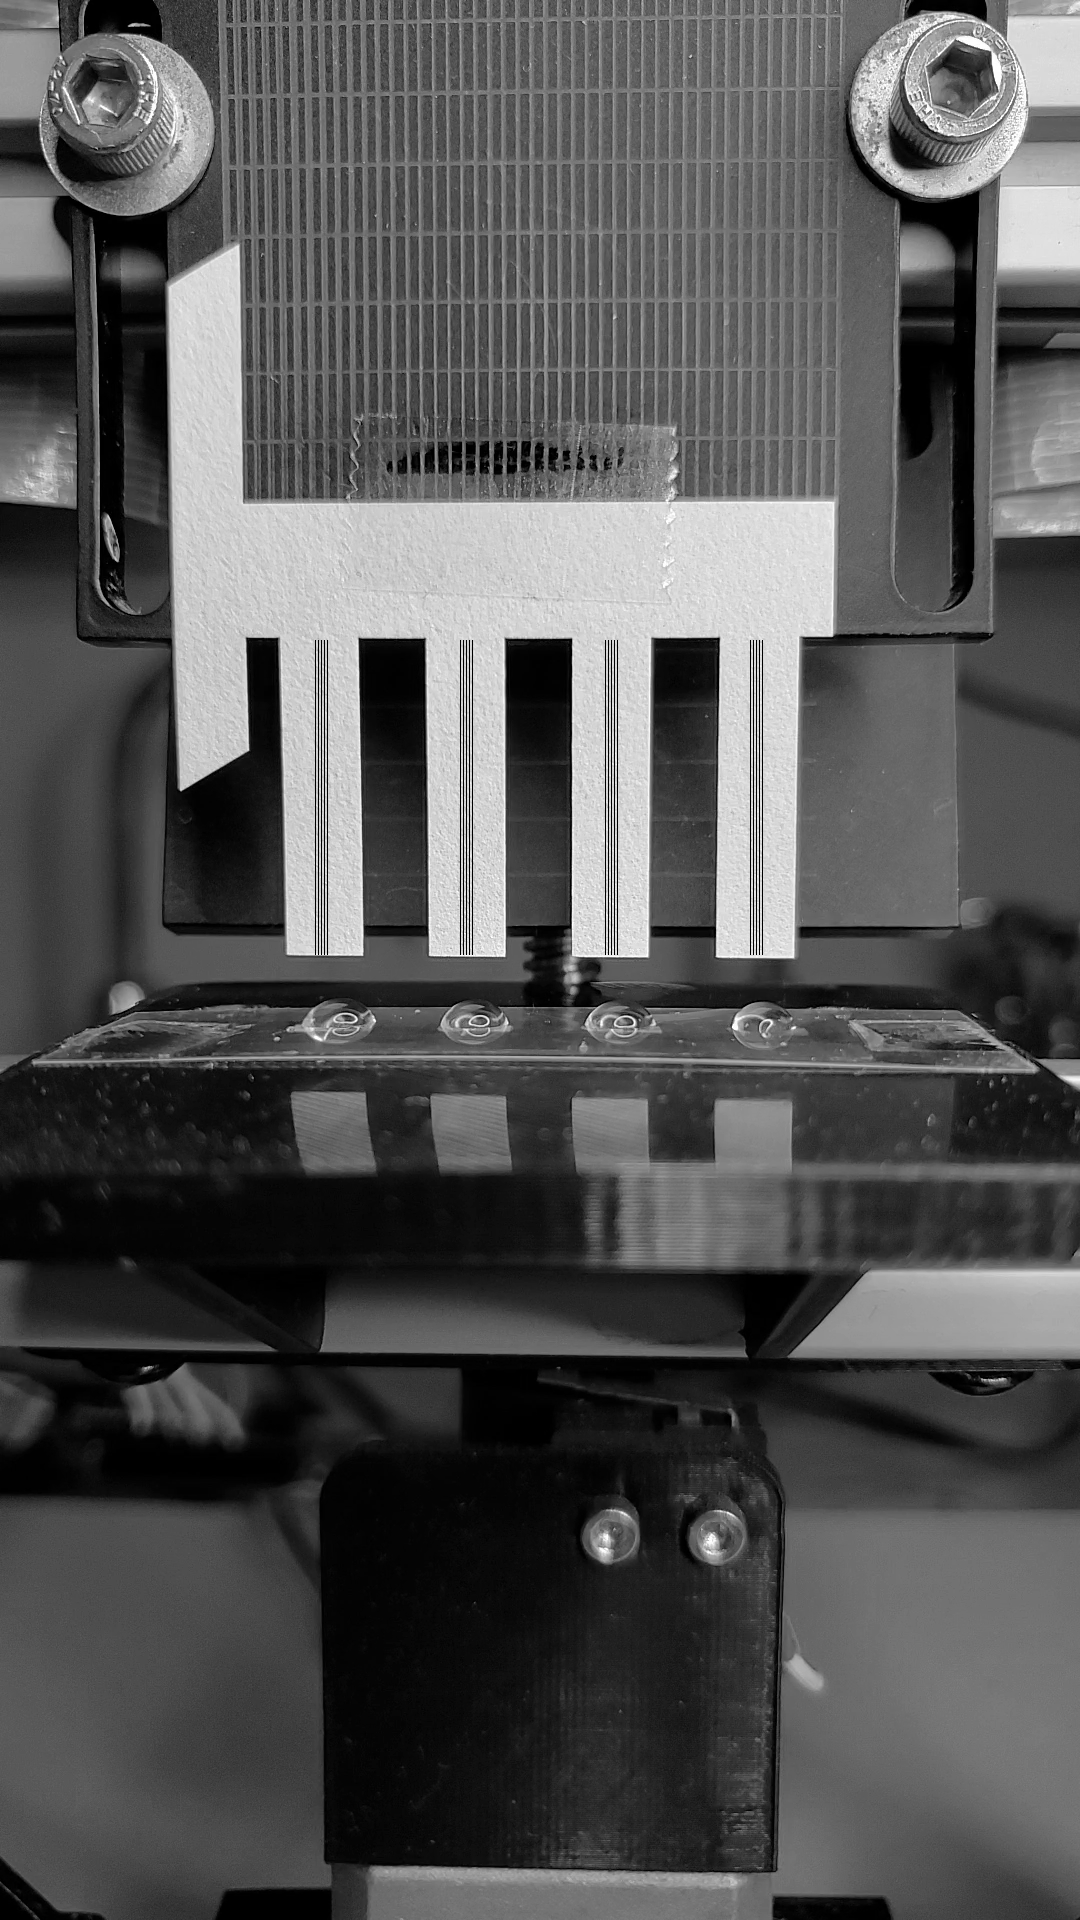

'\n!! What you need to check before moving forward !!\n1. the line is inside of paperchip, especially not over the edge of sample loading side\n2. the drop has not touched the chip at the frame you pick to start\n'

In [75]:
#EDITABLE FOR DATA COLLECTION

file_path = "/content/drive/MyDrive/PFAS_Project/Tucson Water/Secondary effluent/SeungJu"
os.chdir(file_path)

videoName = 'TW-15.10ngMyoglobin.mp4'

axes = 'V' # H - horizontal, V - vertical
start = int(640)
end = int(955)# #pixel along the channel
location = int(321) #Row/channel initial position for horizontal chip/Verticla chip would be column (moves horizontally)
channelgap = int(145) #jump from channel to chnl in px distance
channelnum = int(4) # the number of channels per chip

lanenum = int(5) # how many lanes in one channel being analyzed, required: odd
lanestep = int(3) # px distance between each lane, required: >=3
framestart = int(50) # analyze the video from which frame
duration = int(350) # how many frames will be analyzed

# show example lanes in each channel
# show where is the sample stage at start frame
examplebounds_multiLane(videoName, location, start, end, axes, channelgap, channelnum, lanestep=lanestep, lanenum=lanenum, frame=framestart)
# if want to see where is the flow at end frame
# examplebounds_multiLane(videoName, location, start, end, axes, channelgap, channelnum, lanestep=lanestep, lanenum=lanenum, frame=framestart+duration)

'''
!! What you need to check before moving forward !!
1. the line is inside of paperchip, especially not over the edge of sample loading side
2. the drop has not touched the chip at the frame you pick to start
'''

**Actual flow analysis**

Each flow profile will be cut to start around 20 pixels
Analyzing Ch1_Lane1
Maximum flow (pixels): 155


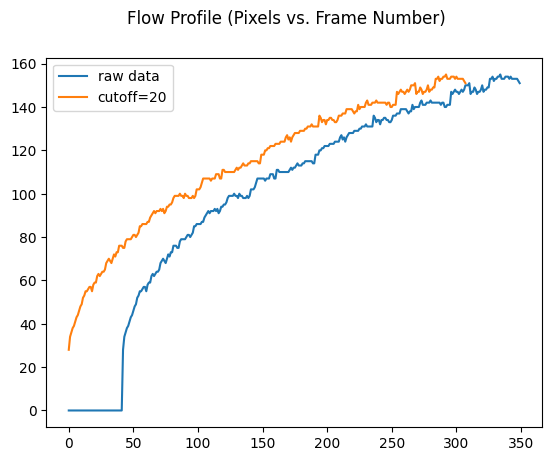

------------------------------------------------------------------------
Analyzing Ch1_Lane2
Maximum flow (pixels): 151


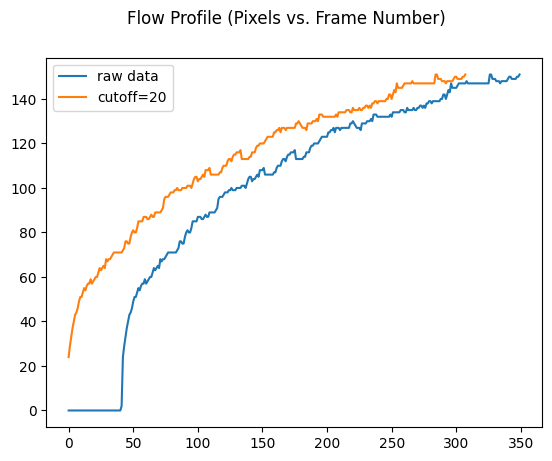

------------------------------------------------------------------------
Analyzing Ch1_Lane3
Maximum flow (pixels): 157


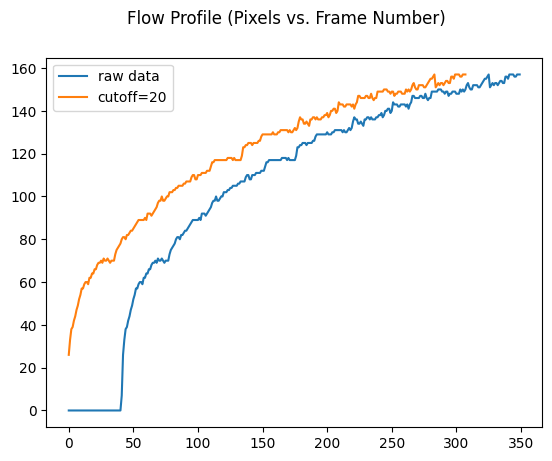

------------------------------------------------------------------------
Analyzing Ch1_Lane4
Maximum flow (pixels): 160


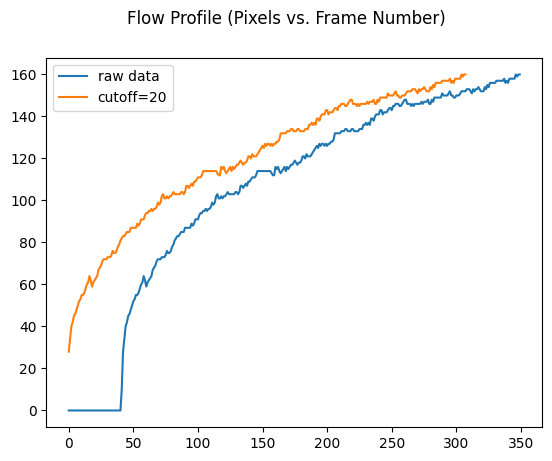

------------------------------------------------------------------------
Analyzing Ch1_Lane5
Maximum flow (pixels): 162


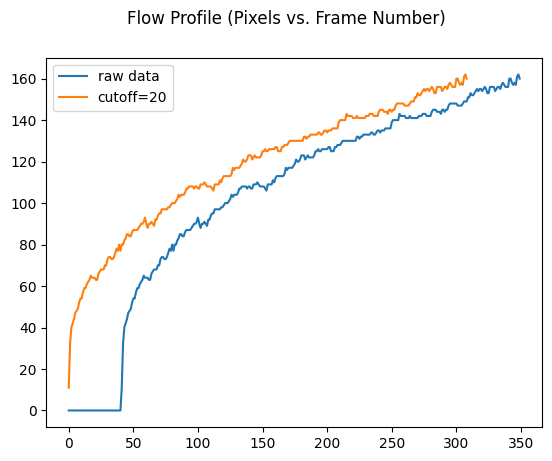

------------------------------------------------------------------------
Analyzing Ch2_Lane1
Maximum flow (pixels): 163


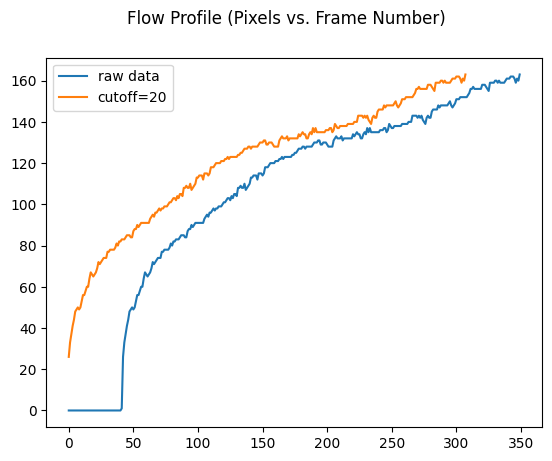

------------------------------------------------------------------------
Analyzing Ch2_Lane2
Maximum flow (pixels): 160


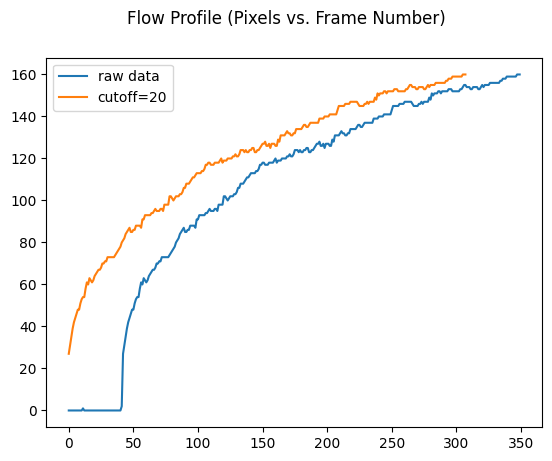

------------------------------------------------------------------------
Analyzing Ch2_Lane3
Maximum flow (pixels): 157


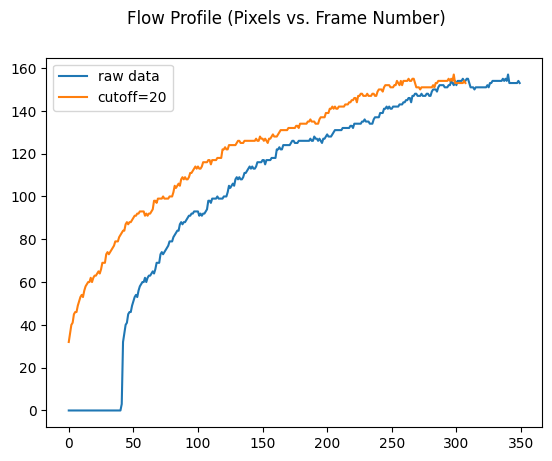

------------------------------------------------------------------------
Analyzing Ch2_Lane4
Maximum flow (pixels): 161


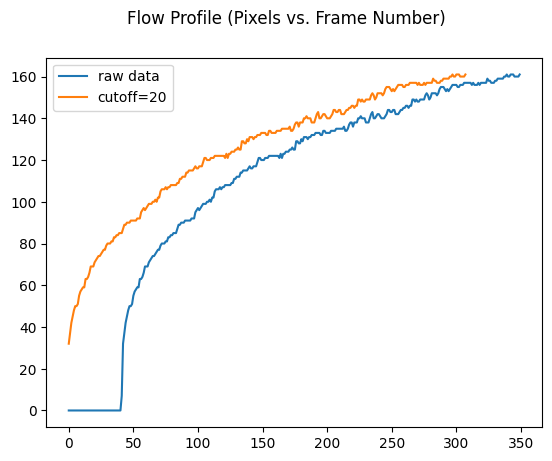

------------------------------------------------------------------------
Analyzing Ch2_Lane5
Maximum flow (pixels): 163


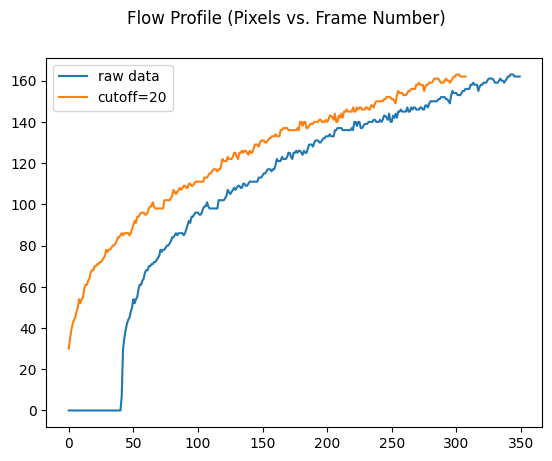

------------------------------------------------------------------------
Analyzing Ch3_Lane1
Maximum flow (pixels): 158


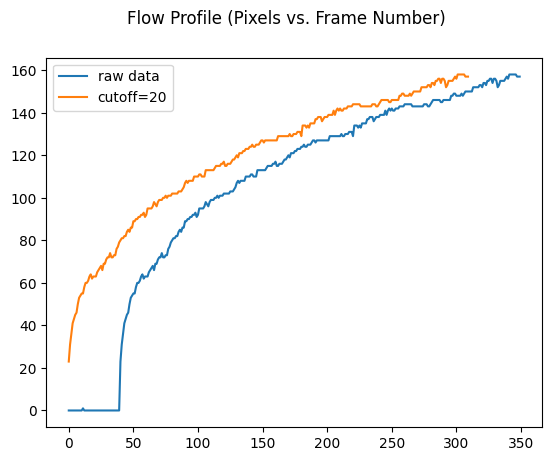

------------------------------------------------------------------------
Analyzing Ch3_Lane2
Maximum flow (pixels): 157


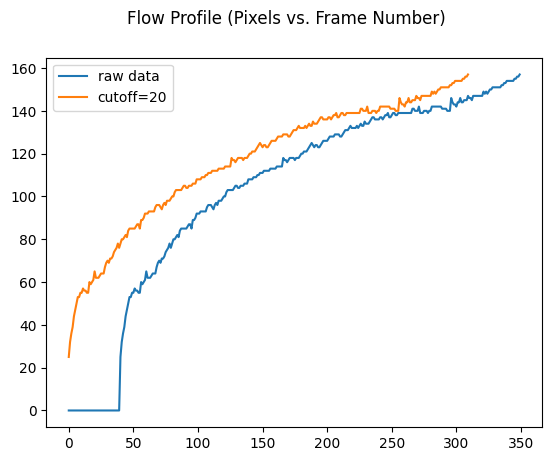

------------------------------------------------------------------------
Analyzing Ch3_Lane3
Maximum flow (pixels): 162


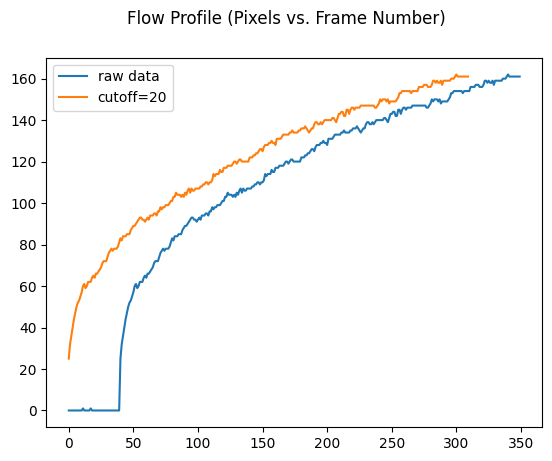

------------------------------------------------------------------------
Analyzing Ch3_Lane4
Maximum flow (pixels): 151


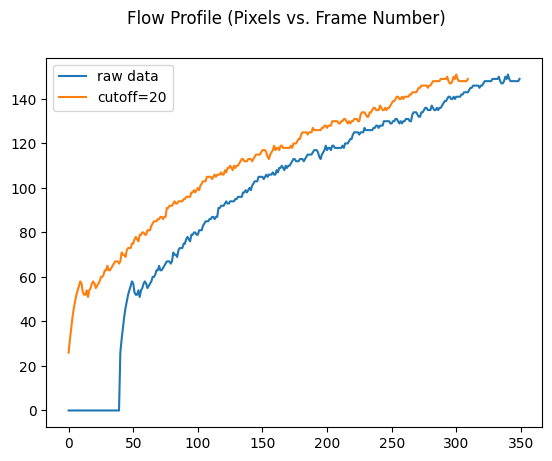

------------------------------------------------------------------------
Analyzing Ch3_Lane5
Maximum flow (pixels): 156


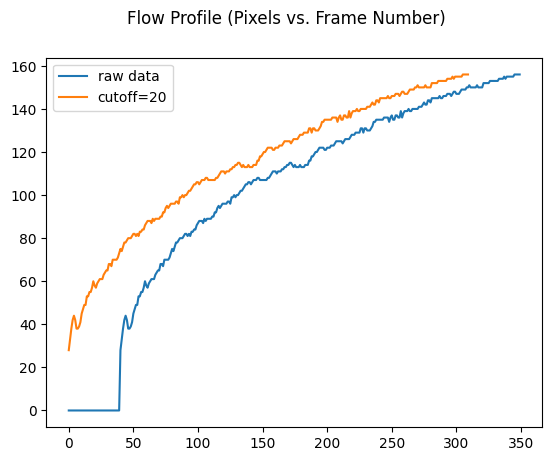

------------------------------------------------------------------------
Analyzing Ch4_Lane1
Maximum flow (pixels): 154


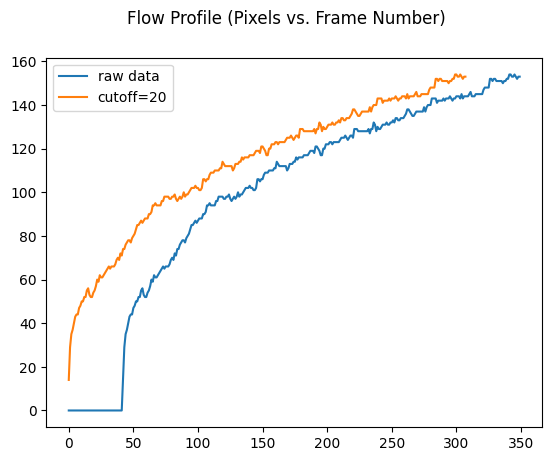

------------------------------------------------------------------------
Analyzing Ch4_Lane2
Maximum flow (pixels): 148


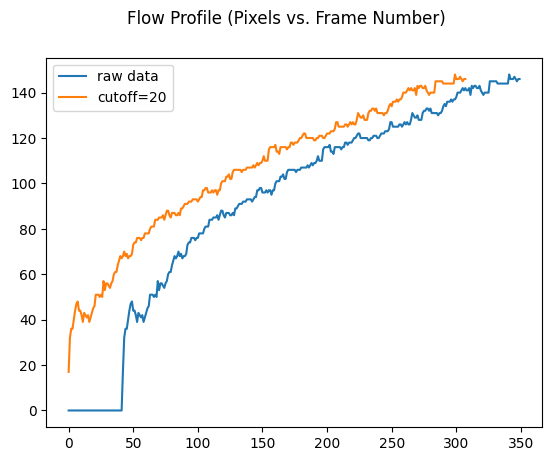

------------------------------------------------------------------------
Analyzing Ch4_Lane3
Maximum flow (pixels): 152


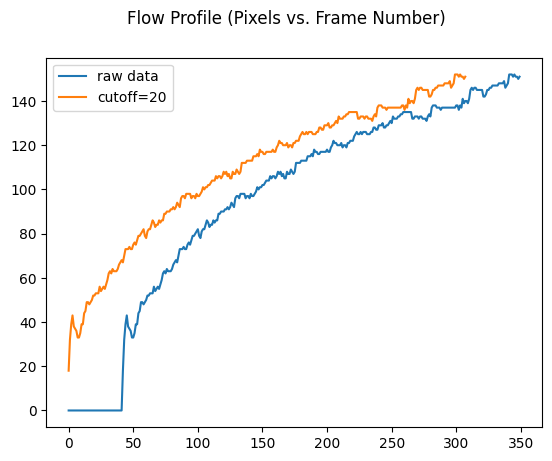

------------------------------------------------------------------------
Analyzing Ch4_Lane4
Maximum flow (pixels): 156


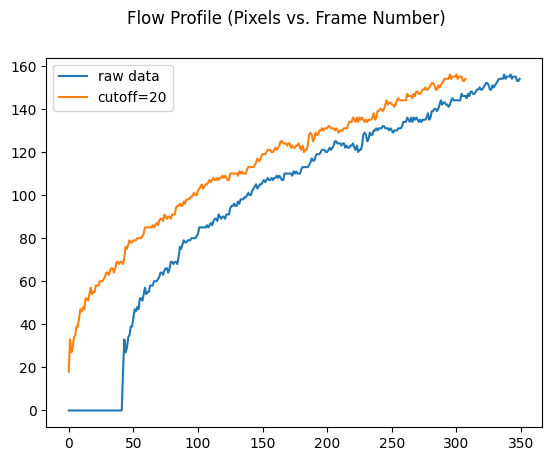

------------------------------------------------------------------------
Analyzing Ch4_Lane5
Maximum flow (pixels): 153


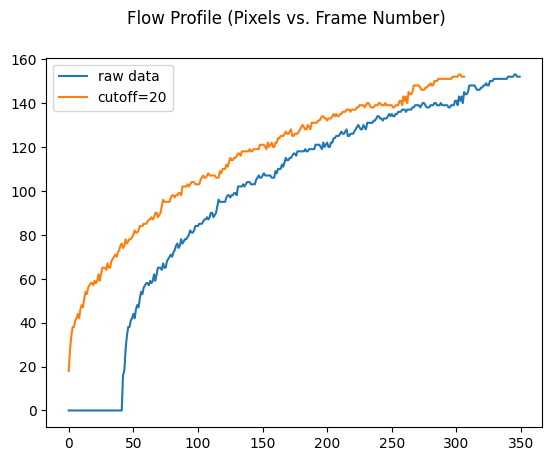

------------------------------------------------------------------------


In [76]:
# threshold = the brightness change in a pixel within the flow lane that is considered to be high enough to count to the flow
# If brightness change exceeds this value, the pixel will be considered as wet counting towards flow distance
# Note: Lower the threshold too much will potentially introduce more noise to flow profile
#       since pixels with random intensity fluctuation (not wetting) may be counted.
# threshold = 10
threshold = 10

# the option to cut the flow profile to a similar start
cutoff_option = True
cutoff = 20 # pixels

flowData = pd.DataFrame()
flowData_cutoff = pd.DataFrame()

#flowData, _ = flowAnalysis_multiLane(videoName, location, start, end, axes, channelnum, channelgap, threshold=10,
#                                        lanestep=lanestep, lanenum=lanenum, framestart=framestart, duration=duration)
flowData, flowData_cutoff = flowAnalysis_multiLane(videoName, location, start, end, axes, channelnum, channelgap, threshold=threshold,
                                                   lanestep=lanestep, lanenum=lanenum, framestart=framestart, duration=duration,
                                                   cutoff_option=cutoff_option, cutoff=cutoff)


**(optional) Check flow profiles before save**

In [77]:
display(flowData_cutoff)
display(flowData)

,Ch1_Lane1,Ch1_Lane2,Ch1_Lane3,Ch1_Lane4,Ch1_Lane5,Ch2_Lane1,Ch2_Lane2,Ch2_Lane3,Ch2_Lane4,Ch2_Lane5,Ch3_Lane1,Ch3_Lane2,Ch3_Lane3,Ch3_Lane4,Ch3_Lane5,Ch4_Lane1,Ch4_Lane2,Ch4_Lane3,Ch4_Lane4,Ch4_Lane5
0,28,24,26,28,11,26,27,32,32,30,23,25,25,26,28,14,17,18,18,18.0
1,34,29,33,34,32,33,31,36,37,35,31,32,32,32,33,29,32,32,33,28.0
2,36,33,38,40,40,37,35,40,42,39,36,36,36,37,38,35,36,39,27,34.0
3,38,37,39,42,42,41,39,41,45,42,41,39,40,42,42,37,36,43,29,38.0
4,39,40,42,45,44,44,42,45,48,44,43,44,44,46,44,40,40,38,34,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,153,149,156,158,157,161,159,153,160,162,158,154,161,148,155,154,147,152,155,153.0
304,153,149,156,160,158,159,159,153,160,162,158,154,161,148,155,153,146,151,155,152.0
305,153,150,157,159,157,161,160,153,160,162,158,155,161,148,156,152,145,151,153,152.0
306,152,150,157,160,161,160,160,154,160,162,158,155,161,148,156,153,146,150,153,152.0


,Ch1_Lane1,Ch1_Lane2,Ch1_Lane3,Ch1_Lane4,Ch1_Lane5,Ch2_Lane1,Ch2_Lane2,Ch2_Lane3,Ch2_Lane4,Ch2_Lane5,Ch3_Lane1,Ch3_Lane2,Ch3_Lane3,Ch3_Lane4,Ch3_Lane5,Ch4_Lane1,Ch4_Lane2,Ch4_Lane3,Ch4_Lane4,Ch4_Lane5
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,153,149,156,158,158,161,159,153,160,162,158,155,161,148,156,154,147,152,155,153
346,153,149,156,160,157,159,159,153,160,162,158,155,161,148,156,153,146,151,155,153
347,153,150,157,159,161,161,160,153,160,162,157,156,161,148,156,152,145,151,153,152
348,152,150,157,160,162,160,160,154,160,162,157,156,161,148,156,153,146,150,153,152


**Save data to google sheets**
- create a new gsheet with video name
- raw flow profiles --> "RawData"
- cleaned --> "cutoff=?px"

In [78]:
# Save the data to google sheets
gc = gspread.authorize(creds)
sh = gc.create(str(videoName))
_  = sh.add_worksheet(title='RawData', rows="100", cols="20")
ws = gc.open(str(videoName)).worksheet('RawData')
gd.set_with_dataframe(ws, flowData)

if cutoff_option:
  sheetName= f'cutoff={cutoff}px'
  ws = sh.add_worksheet(title=sheetName, rows="100", cols="20")
  ws = gc.open(str(videoName)).worksheet(sheetName)
  gd.set_with_dataframe(ws, flowData_cutoff)

**Go check your recent gsheets**
- https://drive.google.com/drive/u/1/home
- https://docs.google.com/spreadsheets/u/1/

# Testing blocks

###*Test1: what is initialLane and currentLane in function flowAnalysis*

In [ ]:
video=cv2.VideoCapture('/content/drive/MyDrive/Yisha/PFAS data/03272024_Myoglobin/100agPFOA.100pgMyoglobin.1.mp4')
video=cv2.VideoCapture(videoName)
print(f'Total frame number: {video.get(cv2.CAP_PROP_FRAME_COUNT)}')

exampleBounds(videoName, location, start, end, axes)
laneLength = defineLane(start, end)


success, image = video.read()
#cv2_imshow(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#cv2_imshow(gray)
initialLane = []
for i in laneLength:
  triplet = []
  for j in range(-1, 2):
    if axes == 'H':
      triplet.append(gray[location + j, i])
    elif axes == 'V':
      triplet.append(gray[i, location + j])
  initialLane.append(np.average(triplet))


desired_frame_number = 300
video.set(cv2.CAP_PROP_POS_FRAMES, desired_frame_number)
success, image = video.read()
print(success)
#cv2_imshow(image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)
currentLane = []
for i in laneLength:
  triplet = []
  for j in range(-1, 2):
    if axes == 'H':
        triplet.append(gray[location + j, i])
    elif axes == 'V':
      triplet.append(gray[i, location + j])
  currentLane.append(np.average(triplet))

video.release()


plt.figure()
plt.plot(initialLane, label='Initial Lane')
plt.plot(currentLane, label='Current Lane')
plt.legend()
plt.show()

Total frame number: 1032.0


NameError: name 'exampleBounds' is not defined

##*Test2: where to cut of a flowprofile*

In [ ]:
def flowCutoff(data, cutoff=20):
  '''
  Cut the flow profile to remove the initial plauteu stage, and have a start around at the cutoff value.
  It will search the fist value less than the cutoff from the back of the list, and cut from there.

  Parameters:
  "data" = the flow profile to be cut
  "cutoff" = the distance (pixels) you want the cut flow profile to start from
  '''
  for i in range(len(data)):
    if data[-(i+1)]<=cutoff:
      if cutoff-data[-(i+1)] < data[-i]-cutoff:
        return data[-(i+1):]
      else:
        return data[-i:]
  print(f'The flow profile remains same since no value less than {cutoff} has been found.')
  return data

data = [12, 24, 31, 39, 37, 39, 40, 44, 43, 47, 49]
flowCutoff(data, cutoff=20)
